In [35]:
import pickle5 as pickle
import matplotlib.pyplot as pl
import sys
import numpy as np

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'
colors = [red, green, blue, yellow, darkblue]

cycle_time = 1.87096 
fullpath = '/Users/tgordon/research/exomoons_jwst/JexoSim/output/OOT_SNR_NIRSpec_BOTS_PRISM_Kepler-1513 b_2020_11_23_1950_27.pickle'
result = pickle.load(open(fullpath, 'rb'))
nhours = 32

filename = fullpath.split('/')[-1]
parts = filename.split('_')
instrument = parts[2]
mode = parts[3]
filt = parts[4]
if not 'PRISM' in filt:
        disp = "/" + parts[5]
        name = parts[6]
else:
        disp=""
        name = parts[5]
filt_disp = '{0}{1}'.format(filt, disp)

In [280]:
wl = result['noise_dic']['All noise']['wl']
means = result['noise_dic']['All noise']['signal_mean_stack']
stds = result['noise_dic']['All noise']['signal_std_stack']

t = np.arange(0, nhours*60*60, cycle_time)

import celerite2
from celerite2 import terms

S0 = float(1e-20)
w0 = 886
term = terms.SHOTerm(S0=S0, w0=w0, Q=1/np.sqrt(2))
gp = celerite2.GaussianProcess(term, mean=0.0)
gp.compute(t/(60*60*24), yerr = 0)
fk = (gp.dot_tril(np.random.randn(len(t))) + 1)

In [281]:
import sys
sys.path.append('./')
import generate_noise

factors, data, wl = generate_noise.variability_factors(fk, wl, cold_temp=5600, hot_temp=5700, effective_temp=5600, spec_path='../JexoSim/archive')

shot_noise = np.random.randn(len(wl), len(t))*stds[:, None]
noisy_lc = means[None, :]*factors.T + shot_noise.T
ppm = (np.sqrt(np.sum(stds ** 2)) / np.sum(means)) / np.sqrt(60 / np.mean(np.diff(t)))

# equal white-noise bins
nbins = 3
total_wn = np.sqrt(np.sum(stds ** 2))
wn_per_bin = total_wn / np.sqrt(nbins)

/Users/tgordon/research/exomoons_jwst/notebooks/generate_noise.py:40: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  flux_hot_kep = quad(int_hot_kep, np.min(kep_band[0])/1e3, np.max(kep_band[0])/1e3)
/Users/tgordon/research/exomoons_jwst/notebooks/generate_noise.py:41: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably

In [283]:
inds = [0]
j = 0
for i in range(nbins):
    sum_wn_squared = 0
    sum_mean = 0
    while (np.sqrt(sum_wn_squared) < wn_per_bin) & (j < len(stds)):
        sum_wn_squared += stds[j] ** 2
        j += 1
    inds.append(j)

lcs = np.zeros((len(t), len(inds)-1))
for i in range(len(inds)-1):
    lcs[:, i] = np.sum(noisy_lc[:, inds[i]:inds[i+1]], axis=1)

import exoplanet as xo
orbit = xo.orbits.SimpleTransitOrbit(period=5.0*60*60, duration=10.6217)
u = [0.44, 0.23]
rp = 0.080359
rm = 0.00378
t0p = 15
t0m = 19
planet = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=rp, t=t/(60*60) - t0p, texp=np.mean(np.diff(t))/(60*60))
    .eval()
).T[0]
moon = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=rm , t=t/(60*60) - t0m, texp=np.mean(np.diff(t))/(60*60))
    .eval()
).T[0]

from astropy.table import table
data = lcs + np.mean(lcs, axis=0)*(moon[:, None] + planet[:, None])
data = table.QTable(data, names=["bin{0}".format(i) for i in range(nbins)])
data.add_column(t, name='time')
data.meta['name'] = name
data.meta['S0'] = S0
data.meta['w0'] = w0
data.meta['t0p'] = t0p
data.meta['t0m'] = t0m
data.meta['rp'] = rp
data.meta['rm'] = rm
data.meta['dur'] = 10.6217
data.meta['ppm'] = ppm
data.meta['filter'] = filt_disp
data.meta['mode'] = mode
data.write(name.replace(" ", "") + ".fits", format='fits', overwrite=True)

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


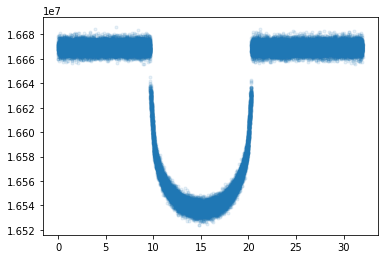

In [284]:
import theano.tensor as tt
import pymc3 as pm
import sys

# need exoplanet version 0.3.3 for the gp submodule.
# Should upgrade specgp to use celerite2 eventually.
import exoplanet as xo
import specgp as sgp
from specgp.distributions import MvUniform
import os
os.system("taskset -p 0xFFFFFFFF %d" % os.getpid())

from astropy.table import Table
from types import SimpleNamespace
filename = 'Kepler-1513b.fits'
data = Table.read(filename)
flux = np.array([data.columns[i] for i in range(len(data.columns)-1)], dtype='float64')
t = np.array(data.columns[-1], dtype='float64')
vars = SimpleNamespace(**data.meta)
pl.plot(t/(60*60), np.sum(flux, axis=0), '.', alpha=0.1)

In [285]:
monoflux = np.sum(flux, axis=0)
oot_flux = np.mean(monoflux[:int(len(t)/4)])
bins = np.linspace(0, 32, 160)
binned = np.histogram(t/(60*60), bins, weights=monoflux/oot_flux - planet)[0] / np.histogram(t/(60*60), bins)[0]

littlebins = np.linspace(0, 32, 16000)
littlebinned = np.histogram(t/(60*60), littlebins, weights=monoflux/oot_flux)[0] / np.histogram(t/(60*60), littlebins)[0]

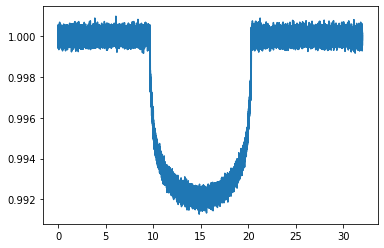

In [286]:
pl.plot(t/(60*60), monoflux / oot_flux)

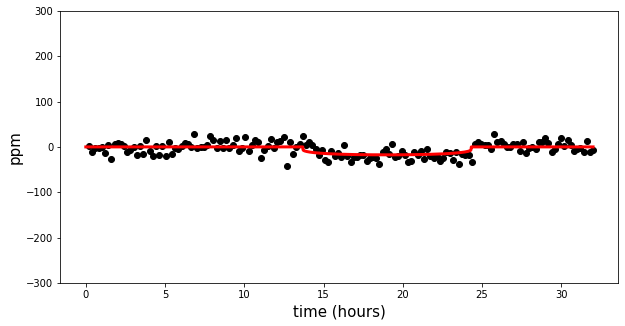

In [287]:
pl.figure(figsize=(10, 5))
#pl.plot(t/(60*60), monoflux/oot_flux - planet)
#pl.plot(t/(60*60), 1e6*(monoflux/oot_flux-1), 'k.', alpha=0.05)
pl.plot(bins[1:], (binned - np.mean(binned[:50])) * 1e6, 'ko')
pl.plot(t/(60*60), moon*1e6, 'r', linewidth=3)
y0, y1 = pl.ylim()
#y0, y1 = -0.01, 0.01
#dy = (y1 - y0)
#pl.ylim(y0 - 0.3*dy, y1+0.3*dy)
pl.ylim(-300, 300)

pl.ylabel('ppm', fontsize=15)
pl.xlabel('time (hours)', fontsize=15)
pl.savefig('/Users/tgordon/Desktop/moon.pdf')

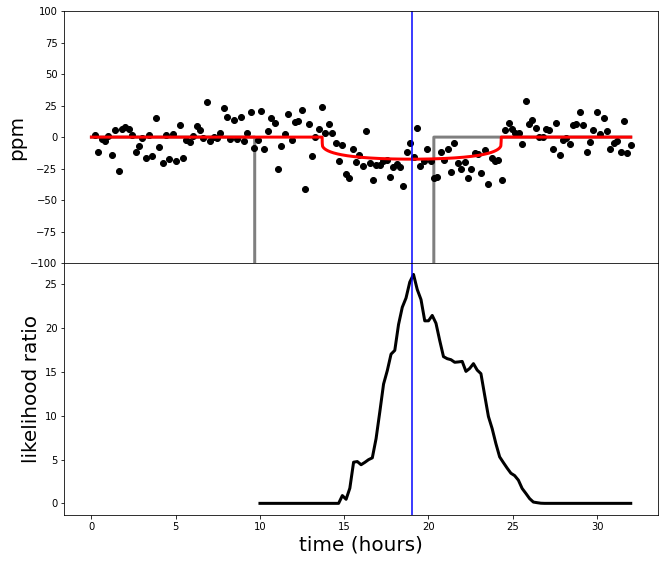

In [288]:
ll = np.loadtxt('ll.out')

fig, axs = pl.subplots(2, 1, figsize=(10, 8), sharex=True)

pl.tight_layout()
pl.subplots_adjust(hspace=0, left=0.15, bottom=0.1)

#pl.plot(bins[1:], (binned - np.mean(binned[:50])) * 1e6, 'ko')
#pl.plot(t/(60*60), moon*1e6, 'r', linewidth=3)
axs[0].plot(bins[1:], (binned - np.mean(binned[:50])) * 1e6, 'ko')
axs[0].plot(t/(60*60), planet*1e6, 'k', linewidth=3, alpha=0.5)
axs[0].plot(t/(60*60), moon*1e6, 'r', linewidth=3)
y0, y1 = axs[0].get_ylim()
dy = (y1 - y0)
axs[0].set_ylim(y0 - 0.3*dy, y1+0.3*dy)

axs[1].plot(t0grid, ll-np.min(ll), 'k', linewidth=3)

axs[0].set_ylim(-100, 100)

axs[0].set_ylabel('ppm', fontsize=20)
axs[1].set_xlabel('time (hours)', fontsize=20)
axs[1].set_ylabel('likelihood ratio', fontsize=20)

axs[0].axvline(19, color='b')
axs[1].axvline(19, color='b')

pl.savefig('/Users/tgordon/Desktop/ganymede.pdf')

In [246]:
oot = monoflux[:np.int(len(t)/4)]
np.std(oot / np.mean(oot)) / np.sqrt(np.int(60 / np.mean(np.diff(t))))

3.879243340216056e-05

In [103]:
noisefloor = np.std(oot / np.mean(oot)) / np.sqrt(np.int((60 * 60 * 10.6217) / np.mean(np.diff(t))))

In [104]:
noisefloor

1.5299488003280406e-06

In [106]:
np.sqrt(noisefloor * 5)# / 0.0024969

0.0027658170585995383

In [136]:
160*cycle_time / (60)

4.989226666666666

In [166]:
ll = np.loadtxt('ll_mars.out')

In [167]:
from scipy.stats import chi2
from scipy.special import erfinv

max(ll)-min(ll)

68.64882087660953

In [168]:
erfinv(1 - chi2.sf(max(ll)-min(ll), 2)) * np.sqrt(2)

7.991573950493906